# 04 - Model Evaluation

## Introduction

### Model Evaluation & Business Insights

After training forecasting models (using Prophet) on historical sales data for each store-product combination, this notebook focuses on evaluating their accuracy and extracting actionable insights. The ultimate goal is to validate the model’s effectiveness and assess its utility for supporting inventory decision-making across Corporación Favorita’s retail network.

---

### Objectives

- **Evaluate model accuracy** using appropriate error metrics (e.g. MAE, RMSE, RMSLE).
- **Compare forecasts vs. actuals** to identify under- and over-performing segments.
- **Visualize forecasting performance** across store-family combinations.
- **Highlight inventory inefficiencies** (e.g. overstock or potential missed demand).
- **Translate forecasts into business insights** for stock optimization.

The results here will help determine where forecasting can improve operational efficiency and how it can best be integrated into real-world inventory planning systems.


## 1. Import and Load Data

In [42]:
# --- Import necessary modules ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# --- Load filtered data ---
filtered_df = pd.read_csv("../data/processed/inventory_prepared.csv")

# --- Load the Actual Sales ---
actual_df = pd.read_csv("../data/train.csv")

# --- Load forecast results ---
forecast_df = pd.read_csv("../forecasts/forecast_results.csv")

# --- Load Store Metadata ---
stores_df = pd.read_csv("../data/stores.csv")

# --- Preview ---
forecast_df.head()

,ds,store_nbr,family,yhat
0,2017-08-02,1,AUTOMOTIVE,5.274178
1,2017-08-03,1,AUTOMOTIVE,4.495939
2,2017-08-04,1,AUTOMOTIVE,5.606048
3,2017-08-05,1,AUTOMOTIVE,4.839023
4,2017-08-06,1,AUTOMOTIVE,3.855964


## 2. Check Forecast Data

### 2.1. Check Forecast Coverage
How many store-family combinations are covered?

In [72]:
coverage = forecast_df.groupby(['store_nbr', 'family']).size().reset_index(name='days_forecasted')
print("Total combinations forecasted:", coverage.shape[0])
print("Example coverage:")
print(coverage.head())


Total combinations forecasted: 1782
Example coverage:
   store_nbr      family  days_forecasted
0          1  AUTOMOTIVE               14
1          1   BABY CARE               14
2          1      BEAUTY               14
3          1   BEVERAGES               14
4          1       BOOKS               14


### 2.2. Check Time Range and Gaps 

In [44]:
# Check forecast date range
print("Forecast start date:", forecast_df['ds'].min())
print("Forecast end date:", forecast_df['ds'].max())

# Check for missing days per store-family
missing_days = forecast_df.groupby(['store_nbr', 'family'])['ds'].nunique().reset_index(name='days_count')
missing_days = missing_days[missing_days['days_count'] < 16]  # assuming 16 days expected
print("Combinations with missing days:", missing_days.shape[0])


Forecast start date: 2017-08-02
Forecast end date: 2017-08-15
Combinations with missing days: 1782


### 2.2.1. Check completeness per group

In [45]:
# Re-check how many groups have full 14-day forecasts
summary = forecast_df.groupby(['store_nbr', 'family'])['ds'].count().reset_index()
summary.columns = ['store_nbr', 'family', 'days_forecasted']

# Count how many have full forecast length
full_forecast = summary[summary['days_forecasted'] == 14].shape[0]
partial_forecast = summary[summary['days_forecasted'] < 14].shape[0]

print(f"Full 14-day forecasts: {full_forecast}")
print(f"Partial forecasts: {partial_forecast}")


Full 14-day forecasts: 1782
Partial forecasts: 0


## 3. Compare with Actual Sales

### 3.1 Visual Diagnostics

### Actual vs. Forecast for select combinations

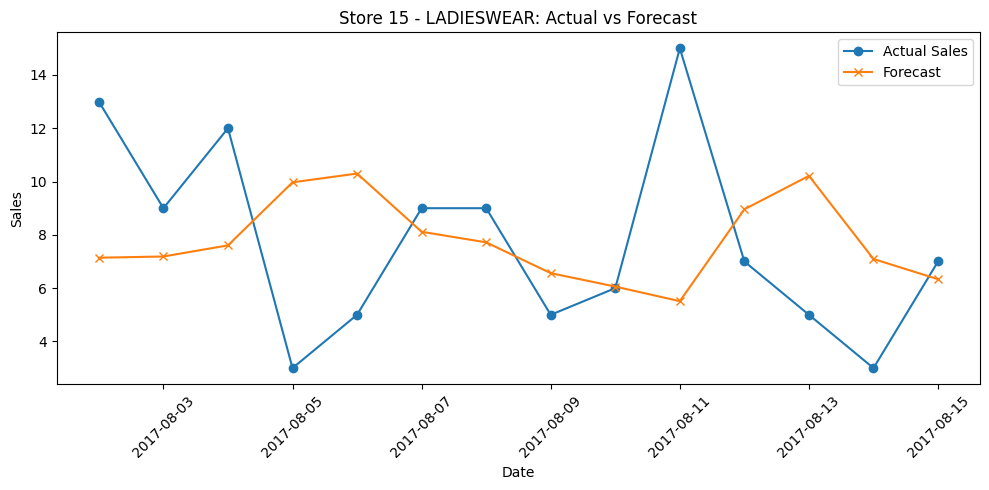

In [55]:
# Load actuals
actuals = actual_df[actual_df['ds'].between("2017-08-02", "2017-08-15")][['ds', 'store_nbr', 'family', 'sales']]

# Merge with forecasts
results = pd.merge(forecast_df, actuals, on=['ds', 'store_nbr', 'family'], how='left')

# Visualize actual vs forecast for a random store-family combination
sample_group = results.groupby(['store_nbr', 'family']).size().reset_index().sample(1)
store = sample_group['store_nbr'].values[0]
family = sample_group['family'].values[0]

plot_df = results[(results['store_nbr'] == store) & (results['family'] == family)]

plt.figure(figsize=(10, 5))
plt.plot(plot_df['ds'], plot_df['sales'], marker='o', label='Actual Sales')
plt.plot(plot_df['ds'], plot_df['yhat'], marker='x', label='Forecast')
plt.title(f"Store {store} - {family}: Actual vs Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Forecast residuals

MAE: 49.92602946826763
RMSE: 164.06815171798343
RMSLE: 0.38014832836915297


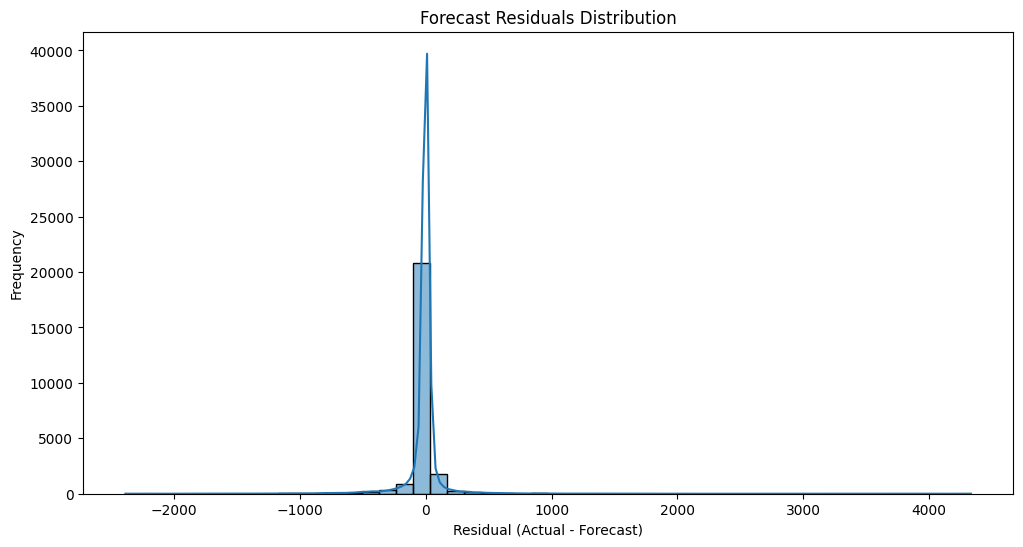

In [56]:
# --- Filter actuals to match forecast window (14 days before 2017-08-16) ---
start_date = forecast_df['ds'].min()
end_date = forecast_df['ds'].max()
actuals_filtered = actuals[(actuals['ds'] >= start_date) & (actuals['ds'] <= end_date)]

# --- Merge forecast and actuals ---
merged = pd.merge(
    forecast_df,
    actuals_filtered,
    how='left',
    on=['ds', 'store_nbr', 'family']
)

# --- Compute residuals ---
merged['residual'] = merged['sales'] - merged['yhat']
merged['abs_error'] = merged['residual'].abs()

# --- Summary statistics ---
print("MAE:", merged['abs_error'].mean())
print("RMSE:", np.sqrt((merged['residual'] ** 2).mean()))
print("RMSLE:", np.sqrt(np.mean((np.log1p(merged['sales']) - np.log1p(merged['yhat'])) ** 2)))

# --- Optional: visualize residuals ---
plt.figure(figsize=(12,6))
sns.histplot(merged['residual'], bins=50, kde=True)
plt.title("Forecast Residuals Distribution")
plt.xlabel("Residual (Actual - Forecast)")
plt.ylabel("Frequency")
plt.show()

> The model predicts well overall—most errors are small and centered around zero. However, some product/store pairs show large deviations, signaling potential risk areas for inventory planning.

### Identify High Error Store-Family Pairs

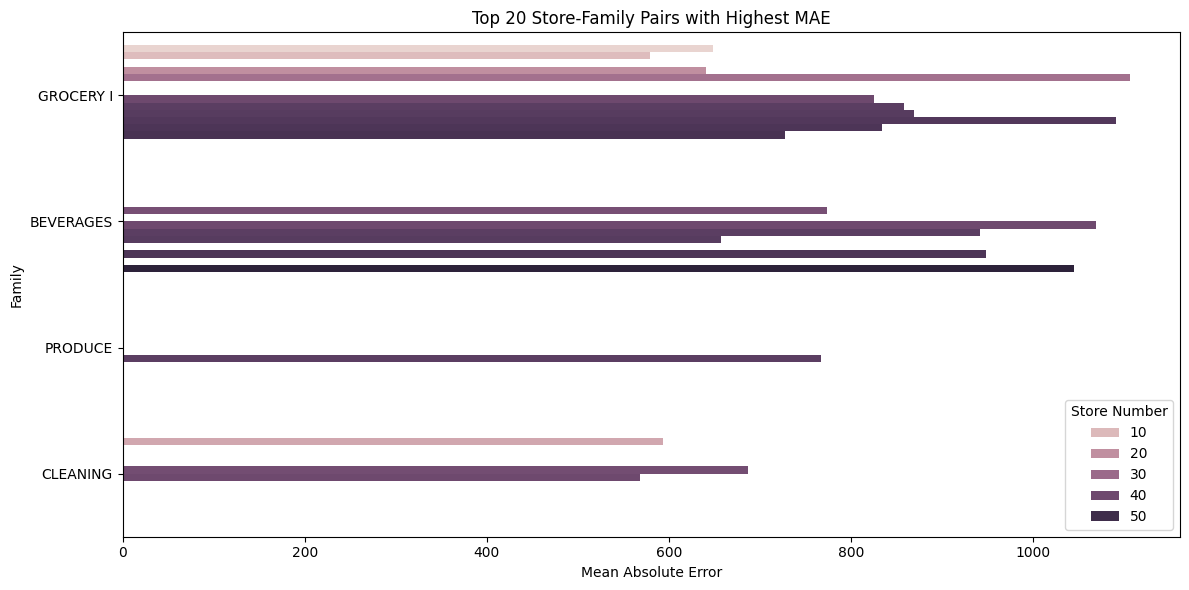

In [57]:
# --- Group by store and family to find average absolute error ---
error_summary = merged.groupby(['store_nbr', 'family'])['abs_error'].mean().reset_index()
error_summary = error_summary.rename(columns={'abs_error': 'mae'})

# --- Sort by highest error to find where model consistently fails ---
high_error_pairs = error_summary.sort_values(by='mae', ascending=False).head(20)

# Visualize the top 20 store-family pairs with highest MAE
plt.figure(figsize=(12, 6))
sns.barplot(data=high_error_pairs, x='mae', y='family', hue='store_nbr')
plt.title("Top 20 Store-Family Pairs with Highest MAE")
plt.xlabel("Mean Absolute Error")
plt.ylabel("Family")
plt.legend(title='Store Number')
plt.tight_layout()
plt.show()

> The model struggles most with high-volume categories like GROCERY I and BEVERAGES, especially across several stores—indicating these pairs may benefit from improved feature engineering or more responsive stocking strategies.

### Error distributions

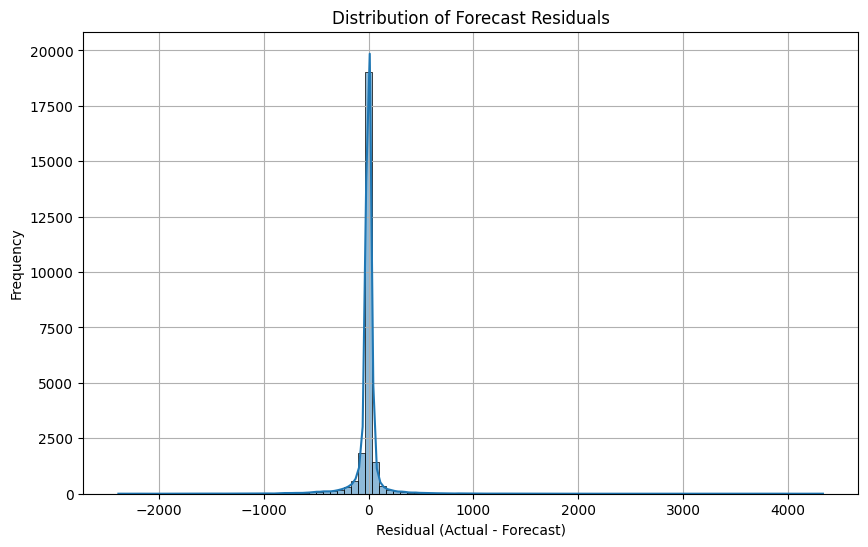

In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load actual and forecast data
actual_df = pd.read_csv("../data/train.csv", parse_dates=['date'])
forecast_df = pd.read_csv("../forecasts/forecast_results.csv", parse_dates=['ds'])

# Align columns
actual_df = actual_df.rename(columns={'date': 'ds'})

# Merge on date, store_nbr, family
merged_df = pd.merge(forecast_df, actual_df, on=['ds', 'store_nbr', 'family'])

# Compute residuals
merged_df['residual'] = merged_df['sales'] - merged_df['yhat']

# Plot error distribution
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['residual'], bins=100, kde=True)
plt.title("Distribution of Forecast Residuals")
plt.xlabel("Residual (Actual - Forecast)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

> This residual distribution shows a sharp peak centered around zero, indicating that most forecasts are quite accurate. However, the long tails suggest that some product/store combinations still experience large errors—highlighting areas for refinement in inventory prediction.

### 3.2 Segment Analysis

### Breakdown by Product Family

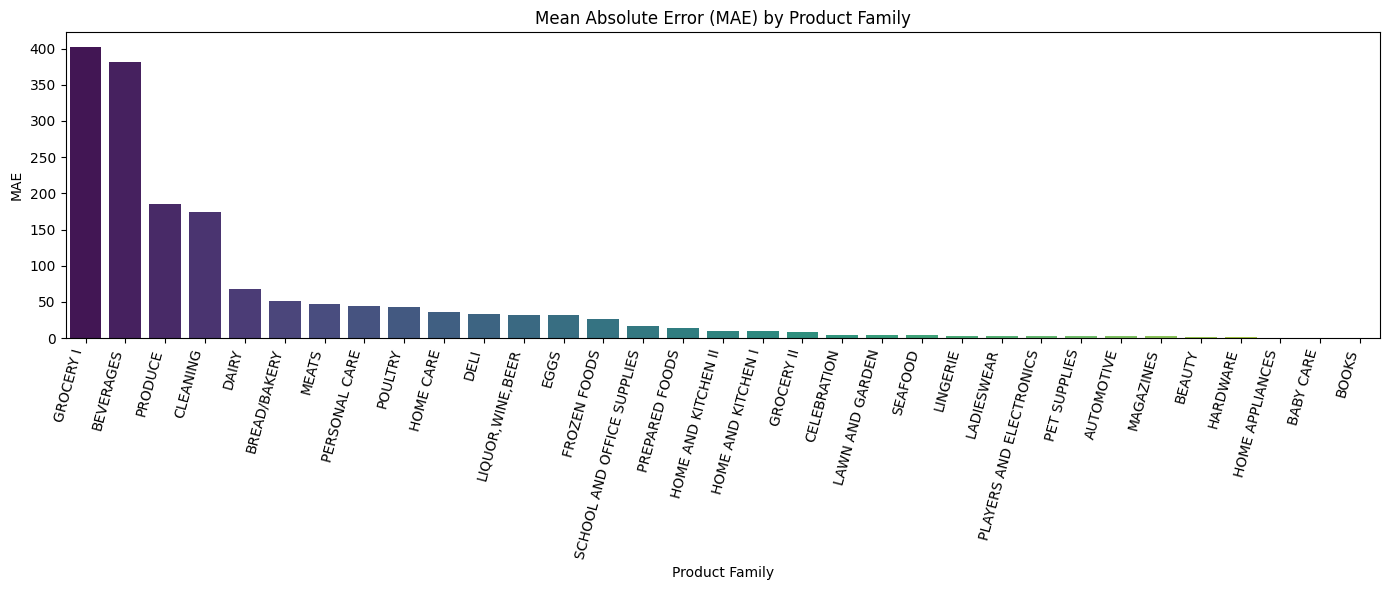

In [62]:
# --- Merge forecasts with actuals ---
merged = pd.merge(
    forecast_df,
    actual_df[['ds', 'store_nbr', 'family', 'sales']],
    how='inner',
    left_on=['ds', 'store_nbr', 'family'],
    right_on=['ds', 'store_nbr', 'family']
)

# --- Compute error ---
merged['abs_error'] = abs(merged['yhat'] - merged['sales'])
merged['squared_error'] = (merged['yhat'] - merged['sales']) ** 2

# --- Merge with store metadata for cluster info ---
merged = pd.merge(merged, stores_df, on='store_nbr', how='left')
# --- Segment Analysis by Family ---
family_errors = merged.groupby('family')[['abs_error', 'squared_error']].mean().reset_index()
family_errors = family_errors.rename(columns={'abs_error': 'MAE', 'squared_error': 'MSE'})

# --- Visualize MAE by Product Family ---
plt.figure(figsize=(14, 6))
sns.barplot(data=family_errors.sort_values('MAE', ascending=False), x='family', y='MAE', palette='viridis')
plt.xticks(rotation=75, ha='right')
plt.title('Mean Absolute Error (MAE) by Product Family')
plt.ylabel('MAE')
plt.xlabel('Product Family')
plt.tight_layout()
plt.show()

> This chart reveals that GROCERY I, BEVERAGES, and PRODUCE have the highest forecast errors (MAE). These categories likely face higher sales volume and variability, making them more sensitive to stockouts or inaccurate demand planning. Conversely, categories like BOOKS, BABY CARE, and HOME APPLIANCES have minimal errors, either due to low sales or stable, infrequent purchases. This segmentation helps prioritize where inventory forecasting improvements matter most.

### Breakdown by Store

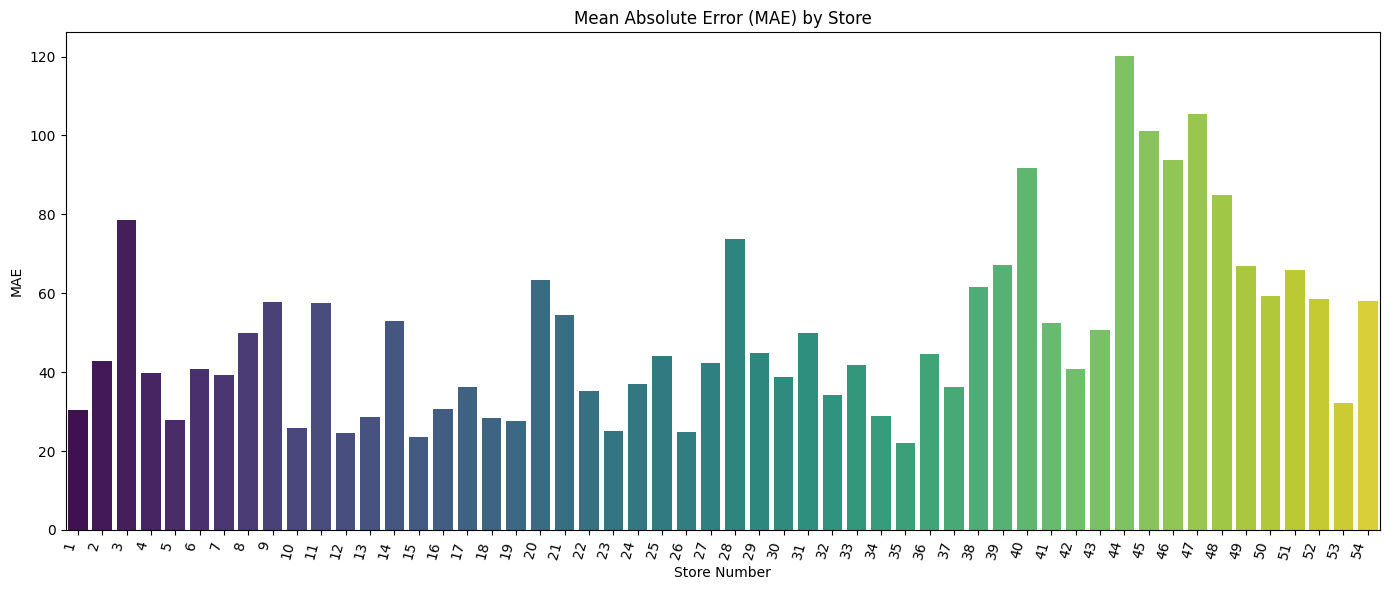

In [64]:
# --- Segment Analysis by Store ---
store_errors = merged.groupby('store_nbr')[['abs_error', 'squared_error']].mean().reset_index()
store_errors = store_errors.rename(columns={'abs_error': 'MAE', 'squared_error': 'MSE'})

# --- Visualize MAE by Store ---
plt.figure(figsize=(14, 6))
sns.barplot(data=store_errors.sort_values('MAE', ascending=False), x='store_nbr', y='MAE', palette='viridis')
plt.xticks(rotation=75, ha='right')
plt.title('Mean Absolute Error (MAE) by Store')
plt.ylabel('MAE')
plt.xlabel('Store Number')
plt.tight_layout()
plt.show()


> This store-level MAE chart shows that Stores 44 to 48 exhibit the highest forecasting errors, indicating volatile or harder-to-predict sales patterns—potentially due to inconsistent promotions, stocking issues, or unique customer behavior. In contrast, Stores 1 to 10 tend to have lower errors, suggesting more stable demand. These insights can help prioritize where to refine stocking and forecasting strategies.

### Breakdown by Cluster

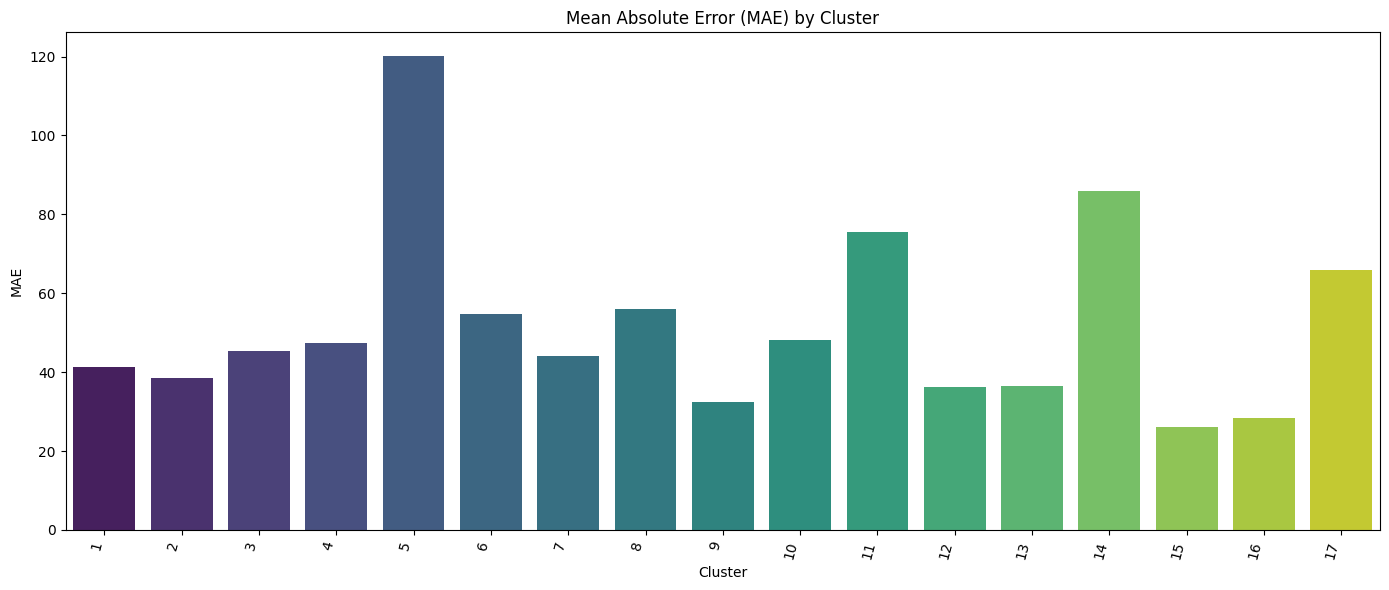

In [65]:
# --- Segment Analysis by Cluster ---
cluster_errors = merged.groupby('cluster')[['abs_error', 'squared_error']].mean().reset_index()
cluster_errors = cluster_errors.rename(columns={'abs_error': 'MAE', 'squared_error': 'MSE'})

# --- Visualize MAE by Cluster ---
plt.figure(figsize=(14, 6))
sns.barplot(data=cluster_errors.sort_values('MAE', ascending=False), x='cluster', y='MAE', palette='viridis')
plt.xticks(rotation=75, ha='right')
plt.title('Mean Absolute Error (MAE) by Cluster')
plt.ylabel('MAE')
plt.xlabel('Cluster')
plt.tight_layout()
plt.show()

> This chart reveals that Cluster 5 and Cluster 14 exhibit the highest Mean Absolute Error (MAE), indicating poor forecast accuracy for stores in these clusters. These clusters likely contain stores with volatile demand patterns or operational inconsistencies. On the other hand, Clusters 15 and 16 perform well with lower MAE, suggesting stable and predictable sales, ideal for applying automated inventory strategies.

### 4. Business Insights

### Which product/store pairs are predictable?

In [66]:
# Merge forecast and actuals on keys
merged = pd.merge(
    forecast_df,
    actuals_filtered,
    left_on=['ds', 'store_nbr', 'family'],
    right_on=['ds', 'store_nbr', 'family'],
    how='inner'
)

# Calculate error metrics per store-family pair
grouped = merged.groupby(['store_nbr', 'family']).agg(
    mae=('sales', lambda y: np.mean(np.abs(y - merged.loc[y.index, 'yhat']))),
    rmse=('sales', lambda y: np.sqrt(np.mean((y - merged.loc[y.index, 'yhat'])**2))),
    rmsle=('sales', lambda y: np.sqrt(np.mean((np.log1p(y) - np.log1p(merged.loc[y.index, 'yhat']))**2))),
    count=('sales', 'count')
).reset_index()

# Filter to combinations with sufficient data
grouped = grouped[grouped['count'] >= 10]

# Add predictability score: lower is better
grouped['predictability_score'] = grouped['rmsle']

# Sort by predictability
predictable = grouped.sort_values('predictability_score')

# Display the result
display(predictable)


,store_nbr,family,mae,rmse,rmsle,count,predictability_score
1753,54,BOOKS,0.000000,0.000000,0.000000,14,0.000000
1769,54,LAWN AND GARDEN,0.000000,0.000000,0.000000,14,0.000000
1768,54,LADIESWEAR,0.000000,0.000000,0.000000,14,0.000000
499,16,BOOKS,0.000000,0.000000,0.000000,14,0.000000
1405,43,LADIESWEAR,0.000000,0.000000,0.000000,14,0.000000
...,...,...,...,...,...,...,...
1078,33,"LIQUOR,WINE,BEER",24.348878,30.526411,1.548905,14,1.548905
1177,36,"LIQUOR,WINE,BEER",35.393593,47.731039,1.858433,14,1.858433
836,26,FROZEN FOODS,29.011563,34.024479,1.886049,14,1.886049
1045,32,"LIQUOR,WINE,BEER",24.094703,42.899734,2.033235,14,2.033235


> Predictable pairs (like Store 54 – BOOKS) show stable or zero sales, making them easy to forecast. Unpredictable ones (e.g., LIQUOR,WINE,BEER) have erratic patterns, indicating challenges for automated inventory planning and a need for deeper analysis.

### Where does the model fail consistently (maybe due to stockouts, volatility)?

In [69]:

# Load actual and predicted data
actual_df = pd.read_csv("../data/train.csv", parse_dates=["date"])
forecast_df = pd.read_csv("../forecasts/forecast_results.csv", parse_dates=["ds"])

# Rename and prepare for merge
actual_df.rename(columns={"date": "ds"}, inplace=True)
merged = pd.merge(forecast_df, actual_df, on=["ds", "store_nbr", "family"], how="inner")

# Calculate residuals and absolute error
merged["residual"] = merged["sales"] - merged["yhat"]
merged["abs_error"] = merged["residual"].abs()

# Identify consistently high-error (store, family) pairs
error_summary = (
    merged.groupby(["store_nbr", "family"])["abs_error"]
    .mean()
    .reset_index()
    .rename(columns={"abs_error": "avg_abs_error"})
    .sort_values(by="avg_abs_error", ascending=False)
)

# Display the top 10 store-family pairs with highest average absolute error
print("Top 10 Store-Family Pairs with Highest Average Absolute Error:")

error_summary.head(10)


Top 10 Store-Family Pairs with Highest Average Absolute Error:


,store_nbr,family,avg_abs_error
903,28,GROCERY I,1105.991202
1497,46,GROCERY I,1090.865024
1290,40,BEVERAGES,1068.636692
1752,54,BEVERAGES,1044.560636
1521,47,BEVERAGES,948.540782
1422,44,BEVERAGES,941.806689
1464,45,GROCERY I,869.094668
1431,44,GROCERY I,858.224361
1530,47,GROCERY I,833.924570
1299,40,GROCERY I,824.945292


> This table highlights the top 10 store-family pairs with the highest forecast errors, such as Store 28 – GROCERY I and Store 40 – BEVERAGES. These represent unpredictable demand patterns, likely driven by high variability, promotions, or stock issues—making them critical targets for inventory strategy improvements.

## What does this mean for inventory planning or replenishment?

This data is valuable for inventory planning and replenishment in several key ways:

1. **Identify Unreliable Demand Patterns**

    Store-family pairs with high forecast errors (e.g., GROCERY I at Store 28) show volatile or inconsistent demand. These may suffer from frequent stockouts, ineffective promotions, or poor sales tracking.

    *Use:* Flag these pairs for manual review, add safety stock, or revise stocking policies.

2. **Prioritize Stabilization Efforts**

    Product families like BEVERAGES showing high error across many stores may indicate systemic issues such as supplier delays or poor promotion timing.

    *Use:* Focus on improving data quality, planning inputs, or using alternative forecasting methods for these categories.

3. **Guide Resource Allocation**

    Knowing which store-product combinations are predictable allows more confident automation in those areas and redirects planner attention to problem segments.

    *Use:* Develop adaptive inventory strategies that vary by predictability.

---

**Summary**

The error analysis turns raw forecast accuracy into operational guidance, helping planners reduce risk, improve stock levels, and focus efforts where demand is least predictable.
